In [1]:
# %matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import scipy.optimize as optimize 
import scipy.fftpack as fftpack
import scipy.signal as signal 
import scipy.interpolate as interpolate
import types
# import lmfit

# import mpmath

pylab.rcParams['figure.figsize'] = (15.0, 3.0)
pylab.rcParams['axes.facecolor'] = 'lightgray'
np.set_printoptions(precision=15)

plt.scatter([0, 1], [0,1])
plt.savefig('test.png')

# Helper functions

In [3]:
def gauss(x, mu, sigma, amplitude): 
    return amplitude * np.exp( - ((x - mu) ** 2) / (2 * (sigma**2) ))

def per_gauss(wl, sigma, minWl, maxWl, period, amplitude):
    result = 0.0;
    current = minWl
    i = 0
    while current <= maxWl:
        result += gauss(wl, minWl + (i * period), sigma, amplitude)
        current += period
        i = i + 1
    return result

# Classes that define simulated instruments.

In [4]:
class Spectrograph:
    def __init__(self, xres, nOrders, orderSize, minWl, bgrNoiseMu, bgrNoiseSD, fwhm, precision):
        self.xres = xres
        self.nOrders = nOrders
        self.orderSize = orderSize
        self.bgrNoiseMu = bgrNoiseMu
        self.bgrNoiseSD = bgrNoiseSD
        self.minWl = minWl
        self.maxWl = minWl + orderSize * nOrders
        self.sigma = fwhm / (2 * np.sqrt(2 * np.log(2))) # sd = fhwm / 2sqrt(2ln2)
        self.precision = precision
        self.fac = self.xres / self.orderSize # Constantly used in conversions
    # A spectrograph can observe many beams: a beam is a mapping of wavelength (in nm) to intensity
    def observe(self, beams):
        order_map = np.empty((self.nOrders, 2,))
        observation = np.empty((self.nOrders, self.xres,))
        
        for i in range(0, self.nOrders):
            startWl = self.minWl + (i * self.orderSize)
            endWl = startWl + self.orderSize
            order_space = np.linspace(startWl, endWl, self.xres, endpoint=False)
            order_obs = np.zeros(len(order_space))

            bgrNoise = np.random.normal(self.bgrNoiseMu, self.bgrNoiseSD, len(order_space)) # Background noise
            bgrNoise[bgrNoise < 0.0] = 0.0001
            order_obs += bgrNoise

            # Each mapping in a beam becomes a gaussian
            for beam in beams:
                for wl in beam:
                    order_obs += gauss(order_space, wl, self.sigma, beam[wl])

            # Add shot noise
            order_obs += np.random.normal(0.0, np.sqrt(order_obs) * self.precision, len(order_space))
            
#             plt.scatter(order_space, order_obs)
#             plt.show()
            
            order_map[i] = np.asarray([startWl, endWl])
            observation[i] = order_obs

        return order_map, observation
    
    def pix_to_wl(self, pix):
        return self.minWl + (pix / self.fac)
        
    def wl_to_pix(self, wl):
        return (wl - sgraph.minWl) * self.fac
        
class LFC:
    def __init__(self, intensity, minWl, maxWl, dWl):
        self.intensity = intensity
        self.minWl = minWl
        self.maxWl = maxWl
        self.span = self.maxWl - self.minWl
        self.dWl = np.float64(dWl)
    def getPeaks(self):
        peaks = np.empty(0)
        current = self.minWl;
        while(current <= self.maxWl):
            peaks = np.append(peaks, current)
            current += self.dWl
        return peaks
    def simulate(self):
        sim = {}
        current = self.minWl
        while current <= self.maxWl:
            sim[current] = self.intensity
            current += self.dWl
        return sim

In [5]:
# sgraph = Spectrograph(4000, 80, 10.0, 399.0, 1000.0, 300.0, 0.0075, 1.0)
# lfc = LFC(250000, 400, sgraph.maxWl - 1, 0.03)
# order_map, y = sgraph.observe([lfc.simulate()])
# print(order_map)
# print(y)

# Finding maxima

In [13]:
def plot_spectrum(ss_xs, ss_ys, y_preds, guess_x, fac, sol):
    for i in range(0, len(ss_xs)):
        plt.scatter(ss_xs[i], ss_ys[i], color='magenta')
        plt.plot(ss_xs[i], y_preds[i])
#         plt.scatter(ss_x, ss_obs[i], color='blue')
#         plt.plot(ss_x, pred_obs, color='red')
#         for peak in pred_peaks:
#             plt.axvline((peak - sgraph.minWl) * sgraph.fac, color='green')
#         for peak in lfc_peaks:
#             plt.axvline((peak - sgraph.minWl) * sgraph.fac, color='purple')
#         plt.axvline(guess_x, color='turquoise')
        if i == 0:
#             plt.xlim(sgraph.wl_to_pix(lfc.minWl - 3 * lfc.dWl), sgraph.wl_to_pix(lfc.minWl + 12 * lfc.dWl))
#             plt.xlim(sgraph.wl_to_pix(lfc.minWl - 3 * lfc.dWl), sgraph.wl_to_pix(lfc.minWl - 3 * lfc.dWl) + 50)
            plt.xlim(guess_x - 3 * lfc.dWl * fac, guess_x + 12 * lfc.dWl * fac)
            plt.axvline(guess_x, color='turquoise')
            plt.axvline(sol, color='purple')
        elif i == 1:
            plt.xlim(4100, 4150)
#             plt.xlim(sgraph.wl_to_pix(400), sgraph.wl_to_pix(401))
        plt.show()
#         plt.savefig('lol{}.png'.format(i))
        
    

In [17]:
def get_peaks(shift, lfc, n):
    peaks = np.empty(0)
    current = shift
    for i in range(0, n):
        peaks = np.append(peaks, current)
        current += lfc.dWl
    return peaks
    
def pred_error(y, pred_y, solution, prediction):
    lse = np.mean(np.abs(y - pred_y))
    error = np.abs(solution - prediction) / solution * 3e8
    return lse, error
    
def guess_min(x, y):
    guess_x = x[y > 2000]
    guess_y = y[y > 2000]
    max_idx = signal.argrelextrema(guess_y, np.greater, order=10)
    guess_max_x = guess_x[max_idx]
    guess_max_y = guess_y[max_idx]
    guess_x = guess_max_x[0]
    guess_y = guess_max_y[0]
    return guess_x, guess_y

def find_lfc_peaks(sgraph, lfc, orderId):
    lfc_peaks = lfc.getPeaks()
    
    print('Solution is: {}pix or {}nm'.format(sgraph.wl_to_pix(lfc.minWl), lfc.minWl))

    order_map, obs = sgraph.observe([lfc.simulate()])
    
    bottom = False
    top = False
    mid = False
    orders = []
    order_ranges = []
    # Select relevant orders
    if orderId == 0: # If first order in spectrum
        bottom = True
        orders.append(obs[0])
        order_ranges.append(order_map[0])
        if len(obs) > 1:
            orders.append(obs[1])
            order_ranges.append(order_map[1])
    elif orderId == len(obs) - 1: # else if last
        top = True
        orders.append(obs[-1])
        order_ranges.append(order_map[-1])
        if len(obs) > 1:
            orders.append(obs[-2])
            order_ranges.append(order_map[-2])
    else: # else middle order
        mid = True
        orders.append(obs[orderId - 1])
        order_ranges.append(order_map[orderId - 1])
        orders.append(obs[orderId])
        order_ranges.append(order_map[orderId])
        orders.append(obs[orderId + 1])
        order_ranges.append(order_map[orderId + 1])
        
    # Swap ranges to pixel space
    # Temporary: For now just paste them together
    new_ranges = []
    for i in range(0, len(order_ranges)):
        new_ranges.append([i * sgraph.xres, ((i + 1) * sgraph.xres) - 1])
    order_ranges = new_ranges
        
    ss_xres = 5 * sgraph.xres
    ss_xs = np.empty((len(orders), ss_xres))
    ss_ys = np.empty((len(orders), ss_xres))
    prev_range = None
    # Interpolate selected orders
    for i in range(0, len(orders)):
        order = orders[i]
        order_range = order_ranges[i]
        
        x = np.linspace(order_range[0], order_range[1], sgraph.xres)
        spl = interpolate.UnivariateSpline(x, order, k=3)
        # This is the tricky part. I need the 'distance' between orders, so that I can
        # align them in pixel space correctly. For now, I am assuming that they are adjacent
        ss_x = np.linspace(order_range[0], order_range[1], ss_xres, dtype=np.float64)
        ss_y = spl(ss_x)
        ss_y[ss_y <= 0.0] = 1e-15
        
        ss_xs[i] = ss_x
        ss_ys[i] = ss_y
        
    # Fit on interpolated data
    # Need pred_shift, and pred_shift_wl
    firstRange = order_ranges[0]
    lastRange = order_ranges[-1]
    def per_gauss_fit(wl, shift):
        return per_gauss(wl, sgraph.sigma * sgraph.fac, firstRange[0] + shift, lastRange[0] + shift, 
                         lfc.dWl * sgraph.fac / 2, lfc.intensity)
    
    def err_func(shift):
        err = 0.0
        # Fit the same per_gauss on each order
        for i in range(0, len(ss_xs)):
            err += np.mean(np.abs(per_gauss_fit(ss_xs[i], shift) - ss_ys[i]))
        return err
        
    guess_x, guess_y = guess_min(ss_xs[0], ss_ys[0])
    print('Initial guess for shift is: {}pix or {}nm'.format(np.asarray([guess_x]), sgraph.pix_to_wl(guess_x)))
#     result = optimize.minimize(err_func, guess_x, method='L-BFGS-B', 
#                       options={'ftol':1e-12, 'gtol':1e-12, 'maxiter':20000*(len(ss_x) + 1), 'maxcor': 100000})
#     result = optimize.minimize(err_func, guess_x, method='L-BFGS-B', 
#                       options={'ftol':1e-20, 'gtol':1e-20, 'maxiter':20000*(len(ss_x) + 1), 'disp':True, 
#                                'eps':np.finfo(np.float64).eps, 'maxls':1000000, 'maxfun':10000000, 'maxcor':10})
    result = optimize.minimize(err_func, guess_x, method='L-BFGS-B')
    nfev = result.nfev
    pred_shift = result.x
    pred_shift_wl = sgraph.pix_to_wl(pred_shift)
    
    y_preds = np.asarray([per_gauss_fit(ss_x, pred_shift) for ss_x in ss_xs])
    
    print('Predicted shift is: {}pix or {}nm'.format(np.asarray([pred_shift]), pred_shift_wl))
    print('Number of calls: {}'.format(nfev))
    
#     pred_peaks = get_peaks(pred_shift_wl, lfc, len(lfc_peaks))
    
#     print(lfc_peaks[0:3], lfc_peaks[-3:])
#     print(pred_peaks[0:3], pred_peaks[-3:])
    
#     lse, error = pred_error(ss_y, y_pred, lfc.minWl, pred_shift_wl)
    error = np.abs(lfc.minWl - pred_shift_wl) / lfc.minWl * 3e8
#     print('Least squares error is {}'.format(lse))
    print('Error is: {}m/s'.format(error))
    
#     plot_spectrum(ss_xs, ss_ys, y_preds, guess_x, sgraph.fac, sgraph.wl_to_pix(lfc.minWl))
    
    return error

In [18]:
rand = np.random.random(1)[0]
# def __init__(self, xres, nOrders, orderSize, minWl, bgrNoiseMu, bgrNoiseSD, fwhm, precision):
sgraph = Spectrograph(4000, 80, 10.0, 399.0, 1000.0, 300.0, 0.0075, 1.0)
# def __init__(self, intensity, minWl, maxWl, dWl):
lfc = LFC(250000, 400 + rand, 430 + rand, 0.03)

Solution is: 613.502084885pix or 400.533755212nm
Initial guess for shift is: [ 613.477273863693199]pix or 400.533693185nm
Predicted shift is: [[ 613.502134205832363]]pix or [ 400.53375533551457]nm
Number of calls: 20
Error is: [ 0.092353532129104]m/s


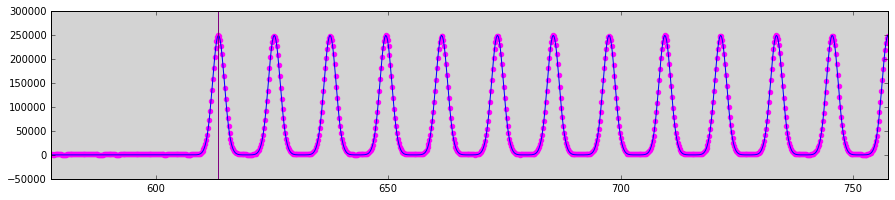

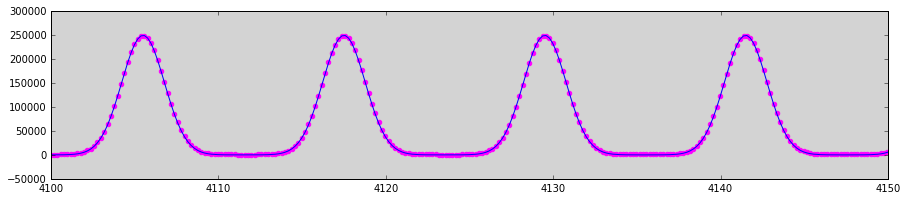

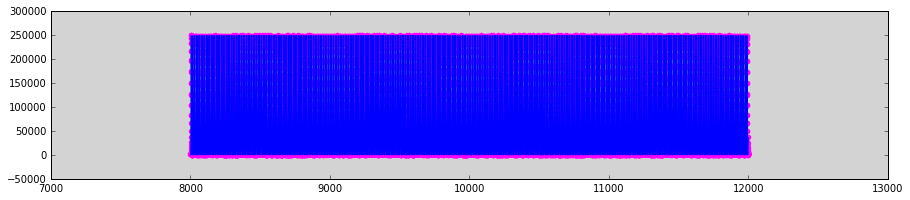

In [16]:
# %%time
error = find_lfc_peaks(sgraph, lfc, 1)

In [ ]:
# %%time
# Make a plot of error to SNR
x = []
y = []
nTests = 10
intenStep = 25000
# nTests = 2
# intenStep = 300000
for intensity in range(20000, 500000, intenStep):
    sgraph = Spectrograph(4000, 80, 10.0, 399.0, 1000.0, 300.0, 0.0075, 1.0)
    lfc = LFC(intensity, 400 + rand, 430 + rand, 0.03)
    # Run 10 tests with each
    x.append(intensity)
    newY = 0.0
    for i in range(0, nTests):
        newY += find_lfc_peaks(sgraph, lfc, 1)
#         newY += np.random.random(1)[0]
    newY = newY / nTests
    y.append(newY)
x = np.asarray(x)
y = np.asarray(y)
plt.plot(x,y)
# plt.show()
plt.savefig('yaay.png'.format(i))

Solution is: 747.890158469pix or 400.869725396nm
Initial guess for shift is: [ 747.850392519625984]pix or 400.869625981nm

# Notes
**For future**:
- Make a table of effect of increasing the lfc intensity
- Create plot of jitter to error
- Resolution = wl of order / (wl to pix ratio) -> 400 / 0.025
- 80 orders [pix, intens, order]
- Further away orders are distorted
- Should use adjacent order
- Generate plots of SNR to error in cm/s
    - Moving Sigma from 2 to 4, R from 50,000 to 20,0000
- Paper submission to PASP

**Open questions**:
- Spectrograph error distribution: what is a good mean and a mean sdev?
- Doing least squares: should I weight according to error? For example, know error increases with intensity